# Playa Events:  Exploratory Data Analysis

#### Outline

- How are events distributed by time? (By Day, By Hour)
- How are events distributed by type?
- Who are the most active camps?
- What are the most common words in event descriptions?
- How are events distributed by location?
- Can we construct an event classifier?

In [2]:
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;
import numpy as np;

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer

import nltk, re, pprint
from nltk.corpus   import stopwords
from nltk          import word_tokenize
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS

import random;
import matplotlib as mpl;

from pylab import *;

Import data from Justin Klein's spreadsheet of events at Burning Man 2017

http://www.justin-klein.com/playaevents-excel-exporter/

In [3]:
col_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2', 
             'Title', 'Description', 'Type', 'Camp', 'Where', 'Extra', 'Link']

df = pd.read_excel('PlayaEvents-2017.xlsx', names=col_names, skip_footer=2);

df.describe()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Title,Description,Type,Camp,Where,Extra,Link
count,3680,3680,3680,3680,3680,3680,3680,3680,3680,3680,3679,3680,3680,3678,3679,3680
unique,120,275,317,329,326,309,207,106,36,3577,3602,13,559,408,537,3647
top,-,-,-,-,-,-,-,-,-,Freetown Christiania,The PlayaPops is glad to offer its fourth seas...,work,-,Open Playa,-,-
freq,3168,2478,2170,2090,2165,2339,2888,3206,3331,5,6,1110,543,269,2604,33


Check what types of data we have

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 16 columns):
Sunday         3680 non-null object
Monday         3680 non-null object
Tuesday        3680 non-null object
Wednesday      3680 non-null object
Thursday       3680 non-null object
Friday         3680 non-null object
Saturday       3680 non-null object
Sunday2        3680 non-null object
Monday2        3680 non-null object
Title          3680 non-null object
Description    3679 non-null object
Type           3680 non-null object
Camp           3680 non-null object
Where          3678 non-null object
Extra          3679 non-null object
Link           3680 non-null object
dtypes: object(16)
memory usage: 460.1+ KB


What does the data look like?

In [4]:
df.tail()

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Title,Description,Type,Camp,Where,Extra,Link
3675,All,All,All,All,All,All,All,All,All,Shrine de Vine,Shrine de Vine is a nature and architecturally...,Art,-,Open Playa,http://elizabethmarley.com,http://burningman.org/event/brc/2017-art-insta...
3676,All,All,All,All,All,All,All,All,All,The Bear,Large burningmanesque bear. Contains the poem ...,Art,-,Open Playa,-,http://burningman.org/event/brc/2017-art-insta...
3677,All,All,All,All,All,All,All,All,All,WeScream,a grounded whimsical ice cream cone made of mi...,Art,-,-,-,-
3678,All,All,All,All,All,All,All,All,All,Rhythmic Ritual Of Love,Rhythmic Ritual Of Love incorporates the most ...,Art,-,Open Playa,-,http://burningman.org/event/brc/2017-art-insta...
3679,All,All,All,All,All,All,All,All,All,Solaris,"Solaris stands as a large, colorfully painted ...",Art,-,Open Playa,-,http://burningman.org/event/brc/2017-art-insta...


Let's take a look at the event distribution by day. The middle of the week (Wednesday) seems to be the busiest. Makes sense. Early in the week people are still arriving and setting things up. Later in the week people get into party mode, and then pack out.

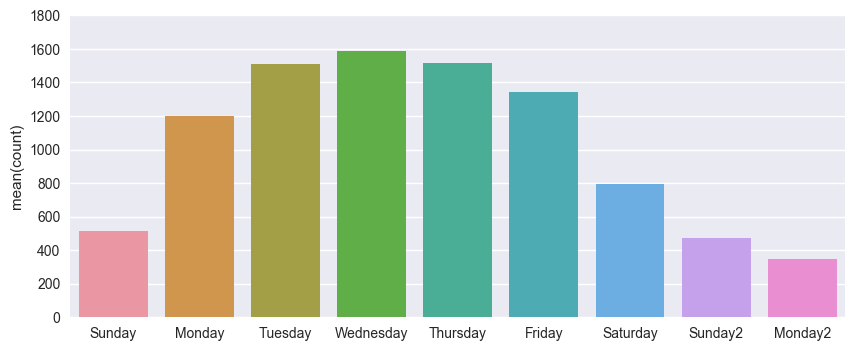

In [9]:
counts = (df[df.columns.values[:9]] != '-').sum().reset_index()
counts.columns = ['day', 'count']

fig = plt.figure(figsize=(10, 4), dpi=100);
axes1 = fig.add_subplot(111); 

sns.barplot(x='day', y='count', data=counts, ax=axes1)

axes1.set_ylim(0, 1800)
axes1.set_xlabel('');

Let's next investigate the event distribution by hour. To do so we'll neeed to construct a function that parses the data and returns a distribution.

In [11]:
def construct_cumulative_times(df):
    # df = dataframe consisting of a list of times
        
    times = [];
    
    for hour in np.arange(0, 24):
        for minutes in np.arange(0, 60, 15):
            time = str(hour)+':'+str(minutes)
            time_date = datetime.datetime.strptime(time, '%H:%M').time()
            times.append(time_date)          
            #times.append(str(hour).zfill(2)+':'+str(minutes).zfill(2))
    
    df_cum = pd.DataFrame(data={'time':times, 'count':[0]*len(times)});

    for row in df.values: 
        if row == '-':
            pass;
        elif row == 'All':
            df_cum['count'].values[:] = df_cum['count'].values[:] + 1;
        else:
            split = row.split("-");

            start_time = datetime.datetime.strptime(split[0], '%H:%M').time()
            end_time   = datetime.datetime.strptime(split[1], '%H:%M').time()
    
            index_first  = df_cum['time'][df_cum['time'] == start_time].index.tolist()[0];
            index_second = df_cum['time'][df_cum['time'] == end_time].index.tolist()[0];
        
            df_cum['count'].values[index_first:index_second] = df_cum['count'].values[index_first:index_second] + 1;
    
    return df_cum;

df_1 = construct_cumulative_times(df['Sunday'])
df_2 = construct_cumulative_times(df['Monday'])
df_3 = construct_cumulative_times(df['Tuesday'])
df_4 = construct_cumulative_times(df['Wednesday'])
df_5 = construct_cumulative_times(df['Thursday'])
df_6 = construct_cumulative_times(df['Friday'])
df_7 = construct_cumulative_times(df['Saturday'])
df_8 = construct_cumulative_times(df['Sunday2'])
df_9 = construct_cumulative_times(df['Monday2'])

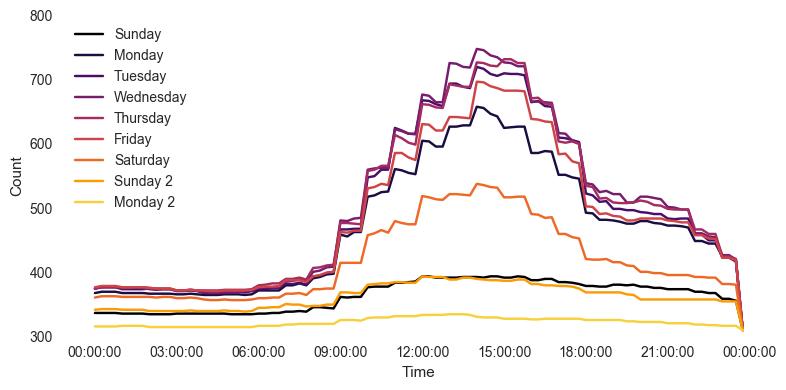

In [12]:
start = 0.0;
stop  = 1.0;
number_of_lines = 10;
cm_subsection = np.linspace(start, stop, number_of_lines) ;
colors = [ cm.inferno(x) for x in cm_subsection ];

fig = plt.figure(figsize=(8, 4), dpi=100);
axes1 = fig.add_subplot(111); 

axes1.plot(df_1['time'], df_1['count'], color=colors[0], ls='-');
axes1.plot(df_2['time'], df_2['count'], color=colors[1], ls='-');
axes1.plot(df_3['time'], df_3['count'], color=colors[2], ls='-');
axes1.plot(df_4['time'], df_4['count'], color=colors[3], ls='-');
axes1.plot(df_5['time'], df_5['count'], color=colors[4], ls='-');
axes1.plot(df_6['time'], df_6['count'], color=colors[5], ls='-');
axes1.plot(df_7['time'], df_7['count'], color=colors[6], ls='-');
axes1.plot(df_8['time'], df_8['count'], color=colors[7], ls='-');
axes1.plot(df_9['time'], df_9['count'], color=colors[8], ls='-');

#axes1.set_xlim(0, 90)
axes1.set_ylim(300, 800);

axes1.set_xticks(np.arange(0, 90000, 10800))

axes1.set_xlabel('Time')
axes1.set_ylabel('Count')

axes1.legend(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday 2', 'Monday 2'])

axes1.grid(False)
axes1.set_facecolor('white')

#axes1.xaxis_date()
#from matplotlib.dates import DateFormatter
#formatter = DateFormatter('%H:%M')
#axes1.xaxis.set_major_formatter(formatter)  

fig.tight_layout()
#fig.savefig('figures/ReflectionResistance/V2O3_Reflection_Resistance.png', bbox_inches='tight', dpi=150);

Looks like things typically start to get going around 9 AM, and really pick up around noon, reaching a peak at around 2-3 PM. This is more or less consistent between different days.

# What are the different types of events?

Let's next examine the event distribution by type. "Work" and "Party" events are the most popular by far. "Fire" events are surprisingly rare, but maybe this is just because fire dancing spontaneously occurs at the big sound stages.

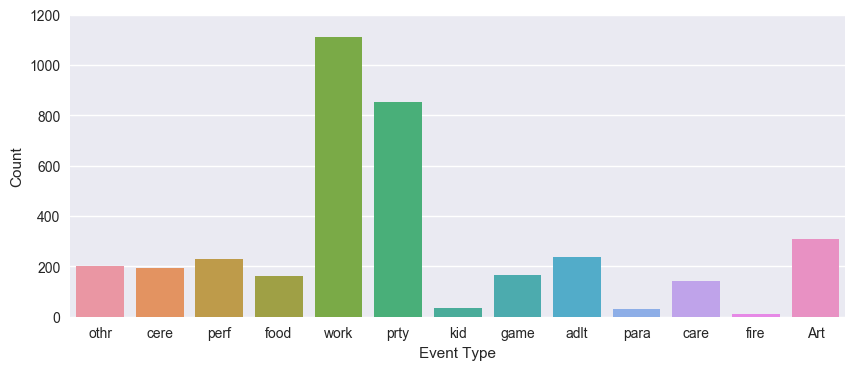

In [17]:
fig = plt.figure(figsize=(10, 4), dpi=100);
axes1 = fig.add_subplot(111); 

sns.countplot(df.Type, ax=axes1)

axes1.set_ylim(0, 1200);
axes1.set_xlabel('Event Type');
axes1.set_ylabel('Count');

# Who are the most active camps?

Naked Heart killing it with almost 100 events. Center Camp Cafe and Feed the Artists basically tied for second, with Camp Contact and Red Lightning close behind.

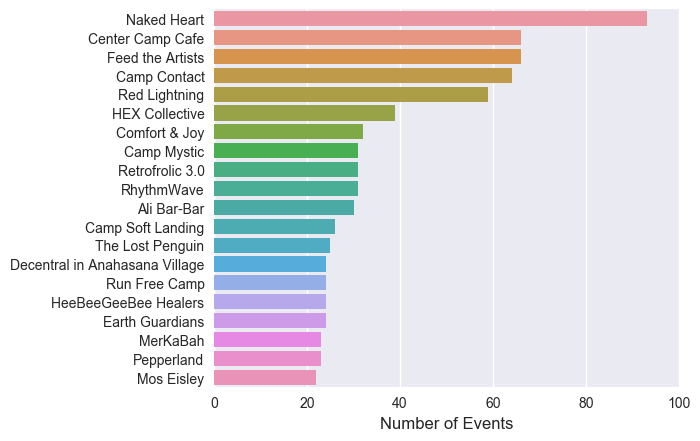

In [29]:
camp_count = df['Camp'].value_counts().reset_index();

camp_count_filtered = camp_count[camp_count['Camp'] > 20];

fig = plt.figure(figsize=(6, 5), dpi=100);
axes1 = fig.add_subplot(111); 

sns.barplot(x='Camp', y='index', data=camp_count_filtered.drop(0), ax=axes1);

#plt.xticks(rotation=90);
axes1.set_xlim(0, 100)
axes1.set_ylabel('');
axes1.set_xlabel('Number of Events', size=12);
axes1.tick_params(axis='both', which='major', labelsize=10);

# Let's take a look at the event descriptions

In [50]:
# Convert Dataframe Column to a joined array of strings
text = ' '.join(list(df.Description.values.astype(str))).lower().replace('\n', '').replace('\r', '');

# How many words in total are there?
print('Character Count = ' + str(len(text)));
print('Total Word Count = ' + str(len(text.split())));
print('Mean Average Word Count = ' + str(len(text.split())/len(df.Description.values)));

Character Count = 1057949
Total Word Count = 179280
Mean Average Word Count = 48.71739130434783


In [51]:
# Convert strings to nltk "token" objects
tokenizer = RegexpTokenizer(r'\w+');
tokens = tokenizer.tokenize(text);

# Convert tokens into an nltk "Text" object
Text = nltk.Text(tokens);

# Filter out stop words
filtered_words = [word for word in Text if word not in stopwords.words('english')];

# Filter out short words
filtered_words_2 = [word for word in filtered_words if len(word) > 3];

fdist_filtered_2 = nltk.FreqDist(filtered_words_2);

Take a look at common collocations

In [52]:
Text.collocations()

burning man; black rock; rock city; radical ritual; happy hour;
default world; dance party; feel free; hip hop; come join; ice cold;
every day; trash fence; creepers photography; come learn; foot tall;
bloody mary; art car; ice cream; photography drugs


For easy visualization, create a word cloud of the most common words in event descriptions.

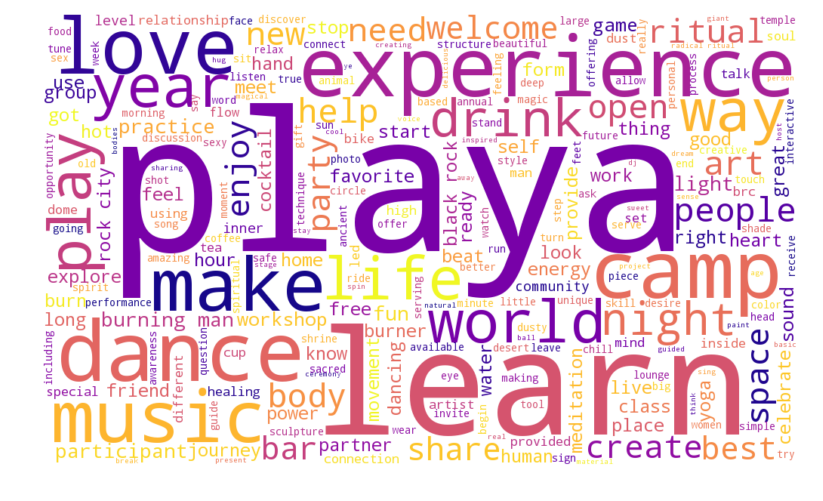

In [56]:
limit = 250
bgcolor = '#FFFFFF'
specific_stopwords = ['come', 'bring', 'join', 'let', 'daily', 'nthe', 'let', 'event', 'want', 'time', 'dj', 'day']
english_stopwords = set(stopwords.words('english')) | STOPWORDS | ENGLISH_STOP_WORDS | set(specific_stopwords)

wordcloud = WordCloud(
    max_words=limit,
    stopwords=english_stopwords,
    background_color=bgcolor,
    width = 1000,
    height = 600,
    colormap = 'plasma'
).generate(text)

fig = plt.figure(figsize=(10, 6), dpi=100);

plt.imshow(wordcloud.recolor(random_state=3), interpolation="bilinear")
plt.axis('off')
plt.show()

# How are event locations distributed?

First define a function to parse location information into a Dataframe

In [50]:
def parse_location(df):
    # df = dataframe consisting of values
    # returns a list of polar coordinates corresponding to location
    
    clocks  = [];
    radials = [];
    types   = [];
        
    for index, row in df[['Where', 'Type']].iterrows():
        location   = row['Where'];
        event_type = row['Type']
        
        if pd.isnull(location):
            pass;
        elif '+' not in location:
            pass;
        else:          
            split = location.split('+');
            
            if len(split) != 2:
                pass;
            else:            
                clock  = split[0];
                radial = split[1];
                clocks.append(clock);
                radials.append(radial);
                types.append(event_type);
            
    df_locations = pd.DataFrame(data={'clocks':clocks, 'radials':radials, 'types':types});
    
    return df_locations;

In [51]:
df_locations = parse_location(df);

print(df_locations['radials'].unique())

print('\n Drop radials with unclear names \n');

df_locations = df_locations[df_locations['radials'] != 'Deep Plaza']
df_locations = df_locations[df_locations['radials'] != ' Cafe']
#df_locations = df_locations[df_locations['radials'] != 'Plaza']
#df_locations = df_locations[df_locations['radials'] != 'Portal']
#df_locations = df_locations[df_locations['radials'] != 'Rods Road']
#df_locations = df_locations[df_locations['radials'] != 'Center Camp Plaza']

print(df_locations['radials'].unique())

print('\n Parse Radials \n')

radial_map = dict();

radial_map['Esplanade'] = 0.9;

radial_map['Awe']       = 1.1;
radial_map['Breath']    = 1.2;
radial_map['Ceremony']  = 1.3;
radial_map['Dance']     = 1.4;
radial_map['Eulogy']    = 1.5;
radial_map['Fire']      = 1.6;
radial_map['Genuflect'] = 1.7;
radial_map['Hallowed']  = 1.8;
radial_map['Inspirit']  = 1.9;
radial_map['Juju']      = 2.0;
radial_map['Kundalini'] = 2.1;
radial_map['Lustrate']  = 2.2;

radial_map['Center Camp Plaza'] = 1.2;
radial_map['Plaza']     = 1.2;
radial_map['Portal']    = 1.2;
radial_map['Rods Road'] = 1.2;

df_locations['radials'] = df_locations['radials'].map(radial_map)

print(df_locations['radials'].unique())

['Awe' 'Eulogy' 'Genuflect' 'Dance' 'Ceremony' 'Portal' 'Inspirit'
 'Rods Road' 'Plaza' 'Fire' 'Breath' 'Center Camp Plaza' 'Esplanade'
 'Hallowed' 'Kundalini' 'Juju' 'Deep Plaza' 'Lustrate' ' Cafe']

 Drop radials with unclear names 

['Awe' 'Eulogy' 'Genuflect' 'Dance' 'Ceremony' 'Portal' 'Inspirit'
 'Rods Road' 'Plaza' 'Fire' 'Breath' 'Center Camp Plaza' 'Esplanade'
 'Hallowed' 'Kundalini' 'Juju' 'Lustrate']

 Parse Radials 

[ 1.1  1.5  1.7  1.4  1.3  1.2  1.9  1.6  0.9  1.8  2.1  2.   2.2]


Convert "hours" to an angle for polar plots

In [52]:
def clock_to_angle(time):
    hour, minutes = time.split(':');
    
    return (2*pi*int(hour)/12) + ((2*pi/12)*int(minutes)/60);

df_locations['clocks'] = df_locations['clocks'].map(clock_to_angle)

print(df_locations['radials'].unique())

df_locations = df_locations.dropna(axis=0)

#plt.figure(figsize=(10, 4));
#sns.distplot(df_locations['clocks'].values)
#plt.xticks(rotation=0);

[ 1.1  1.5  1.7  1.4  1.3  1.2  1.9  1.6  0.9  1.8  2.1  2.   2.2]


Color coding by event type

In [53]:
color_map = dict();

color_map['othr'] = 'grey';
color_map['cere'] = 'purple';
color_map['food'] = 'green';
color_map['work'] = 'brown';
color_map['prty'] = 'blue';
color_map['perf'] = 'gold';
color_map['kid']  = 'cyan';
color_map['game'] = 'pink';
color_map['adlt'] = 'black';
color_map['care'] = 'yellow';
color_map['para'] = 'orange';
color_map['fire'] = 'red';

colors = df_locations['types'].map(color_map)

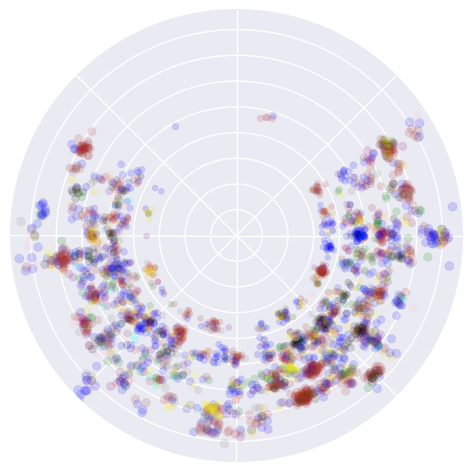

In [54]:
clockJitter   = 0.03*np.random.randn(len(df_locations['clocks'].values));
radial_jitter = 0.03*np.random.randn(len(df_locations['radials'].values));

fig = plt.figure(figsize=(6, 6), dpi=100);
ax = fig.add_subplot(111, polar=True); 

c = scatter(df_locations['clocks'].values + clockJitter, 
            df_locations['radials'].values + radial_jitter, 
            s=20*df_locations['radials'].values, c=colors)

c.set_alpha(0.15)

ax.set_rmax(2.2)

ax.set_theta_zero_location('N')

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
#ax.legend()

show()

There's clearly a lot going on, but it's hard to tell from this plot. Let's take a look at a KDE plot to see if that provides some clearer insight. 

[]

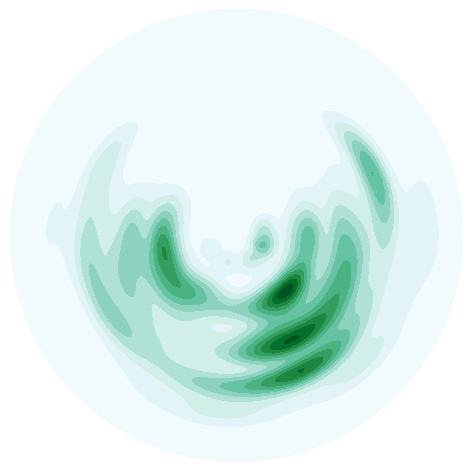

In [11]:
fig = plt.figure(figsize=(6, 6), dpi=100);
ax = fig.add_subplot(111, polar=True); 

sns.kdeplot(df_locations[['clocks', 'radials']], shade=True, ax=ax, gridsize=100, cbar=True)

ax.set_rmax(2.2)
ax.set_theta_zero_location('N')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

Yup. Looks like most events are clustered around the 4-5 o'clock, with another big cluster around 8'o clock. Let's take a closer look at event distribution by type

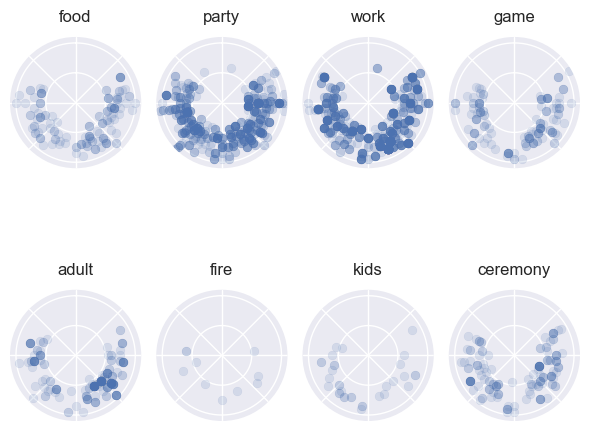

In [22]:
fig = plt.figure(figsize=(6, 6), dpi=100);

ax1 = fig.add_subplot(241, polar=True); 
ax2 = fig.add_subplot(242, polar=True); 
ax3 = fig.add_subplot(243, polar=True); 
ax4 = fig.add_subplot(244, polar=True); 
ax5 = fig.add_subplot(245, polar=True); 
ax6 = fig.add_subplot(246, polar=True); 
ax7 = fig.add_subplot(247, polar=True); 
ax8 = fig.add_subplot(248, polar=True); 

c1 = ax1.scatter(df_locations[df_locations['types'] == 'food']['clocks'].values, 
                 df_locations[df_locations['types'] == 'food']['radials'].values, 
                 s=40)

c2 = ax2.scatter(df_locations[df_locations['types'] == 'prty']['clocks'].values, 
                 df_locations[df_locations['types'] == 'prty']['radials'].values, 
                 s=40)

c3 = ax3.scatter(df_locations[df_locations['types'] == 'work']['clocks'].values, 
                 df_locations[df_locations['types'] == 'work']['radials'].values, 
                 s=40)

c4 = ax4.scatter(df_locations[df_locations['types'] == 'game']['clocks'].values, 
                 df_locations[df_locations['types'] == 'game']['radials'].values, 
                 s=40)

c5 = ax5.scatter(df_locations[df_locations['types'] == 'adlt']['clocks'].values, 
                 df_locations[df_locations['types'] == 'adlt']['radials'].values, 
                 s=40)

c6 = ax6.scatter(df_locations[df_locations['types'] == 'fire']['clocks'].values, 
                 df_locations[df_locations['types'] == 'fire']['radials'].values, 
                 s=40)

c7 = ax7.scatter(df_locations[df_locations['types'] == 'kid']['clocks'].values, 
                 df_locations[df_locations['types'] == 'kid']['radials'].values, 
                 s=40)

c8 = ax8.scatter(df_locations[df_locations['types'] == 'cere']['clocks'].values, 
                 df_locations[df_locations['types'] == 'cere']['radials'].values, 
                 s=40)

c1.set_alpha(0.15);c2.set_alpha(0.15);c3.set_alpha(0.15);c4.set_alpha(0.15);
c5.set_alpha(0.15);c6.set_alpha(0.15);c7.set_alpha(0.15);c8.set_alpha(0.15);

ax1.set_rmax(2.2);ax2.set_rmax(2.2);ax3.set_rmax(2.2);ax4.set_rmax(2.2);
ax5.set_rmax(2.2);ax6.set_rmax(2.2);ax7.set_rmax(2.2);ax8.set_rmax(2.2);

ax1.set_theta_zero_location('N');ax2.set_theta_zero_location('N');
ax3.set_theta_zero_location('N');ax4.set_theta_zero_location('N');
ax5.set_theta_zero_location('N');ax6.set_theta_zero_location('N');
ax7.set_theta_zero_location('N');ax8.set_theta_zero_location('N');

ax1.xaxis.set_ticklabels([]);ax2.xaxis.set_ticklabels([]);ax3.xaxis.set_ticklabels([]);ax4.xaxis.set_ticklabels([]);
ax5.xaxis.set_ticklabels([]);ax6.xaxis.set_ticklabels([]);ax7.xaxis.set_ticklabels([]);ax8.xaxis.set_ticklabels([]);

ax1.yaxis.set_ticklabels([]);ax2.yaxis.set_ticklabels([]);ax3.yaxis.set_ticklabels([]);ax4.yaxis.set_ticklabels([]);
ax5.yaxis.set_ticklabels([]);ax6.yaxis.set_ticklabels([]);ax7.yaxis.set_ticklabels([]);ax8.yaxis.set_ticklabels([]);

ax1.set_title('food');
ax2.set_title('party');
ax3.set_title('work');
ax4.set_title('game');
ax5.set_title('adult');
ax6.set_title('fire');
ax7.set_title('kids');
ax8.set_title('ceremony');

fig.tight_layout();

show()

# Sentiment Analysis

Let's run a quick sentiment analysis with NLTK's VADER algorithm. 

Looks like the overall sentiment score is close to neutral and slightly positive.

If we look at the distribution of scores by event, we see that the descriptions are definitely not negative, only a little positive, and with a large degree of neutrality. The compound score is positive-leaning, but with a large peak near zero.

...although perhaps we shouldn't put too much stock on this particular sentiment analysis. Burners enjoy wordplay, snark, and have their own slang, which may not be adequatly captured.

In [80]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA;

sia = SIA()

polarity_scores = [sia.polarity_scores(str(event)) for event in df.Description.values]

print('Overall Polarity Scores: ' + str(sia.polarity_scores(text)))

Overall Polarity Scores: {'neg': 0.049, 'neu': 0.752, 'pos': 0.199, 'compound': 1.0}


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


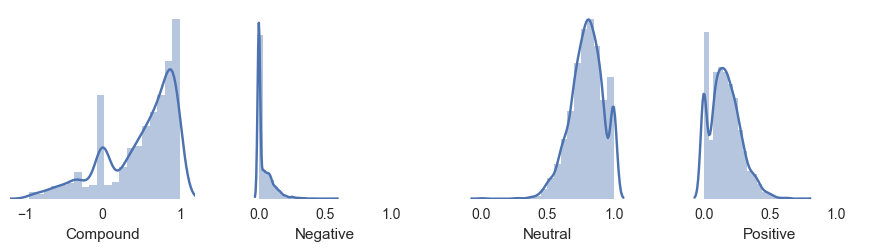

In [85]:
fig = plt.figure(figsize=(11, 2.5), dpi=100);

axes1 = fig.add_subplot(141);axes2 = fig.add_subplot(142);axes3 = fig.add_subplot(143);axes4 = fig.add_subplot(144); 

sns.distplot([event['compound'] for event in polarity_scores], ax=axes1, bins=20, axlabel='Compound')
sns.distplot([event['neg']      for event in polarity_scores], ax=axes2, bins=20, axlabel='Negative')
sns.distplot([event['neu']      for event in polarity_scores], ax=axes3, bins=20, axlabel='Neutral')
sns.distplot([event['pos']      for event in polarity_scores], ax=axes4, bins=20, axlabel='Positive')

axes1.set_xlim(-1.2, 1.2);
axes2.set_xlim(-0.2, 1.2);
axes3.set_xlim(-0.2, 1.2);
axes4.set_xlim(-0.2, 1.2);

axes1.set_ylim(0, 2);
axes2.set_ylim(0, 25);
axes3.set_ylim(0, 3.5);
axes4.set_ylim(0, 5);

axes1.set_yticks([]);axes2.set_yticks([]);axes3.set_yticks([]);axes4.set_yticks([]);

axes1.grid(False);axes2.grid(False);axes3.grid(False);axes4.grid(False);

axes1.set_facecolor('white');axes2.set_facecolor('white');axes3.set_facecolor('white');axes4.set_facecolor('white');

# Let's try to build an event classifier

A similar application is the Facebook Event Classifier, which attempts to categorize events (e.g. parties, concerts, games).

In [56]:
events = df[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2', 
             'Description', 'Type', 'Camp', 'Title']];

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2'];

events[days] = ((events[days] == '-') == False).astype(int);

events = events.dropna(axis=0)

events.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday2,Monday2,Description,Type,Camp,Title
0,1,0,0,0,0,0,0,0,0,"21+ come in, have a cocktail made fresh. There...",othr,FANDANGO!,Slow Burn Lounge
1,1,0,0,0,0,0,0,0,0,"""PlayaSkool presents ‘A New Beginning' with Su...",cere,PlayaSkool,A New Beginning - Burning Man Ritual Sunrise P...
2,1,0,0,0,0,0,0,0,0,Jacobson is a streching methodology; contracti...,othr,Feed the Artists,Jacobson streching
3,1,0,0,0,0,0,0,0,0,Let music move your soul and dancing feet as w...,perf,Center Camp Cafe,Grand Opening of The Sound and Performance Stage
4,1,0,0,0,0,0,0,0,0,Stop by in the morning for these hot off the g...,food,Pepperland,Pepperland Pancakes!


Run the CountVectorizer on the event descriptions and event titles

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english', min_df=6)

X = count_vect.fit_transform(events['Description'].values);
X_titles = count_vect.fit_transform(events['Title'].values);

print(X.shape)
print(X_titles.shape)

(3679, 2936)
(3679, 368)


One-Hot-Encode the camp names

In [158]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

enc = OneHotEncoder();
le  = LabelEncoder();

camps = events['Camp'].values

events['Camp'] = le.fit_transform(camps)

camps = enc.fit_transform(events[['Camp']])

camps.toarray().shape

(3679, 559)

Merge the data on the event description, event title, event day, and camp name.

In [176]:
from scipy import sparse

X = sparse.csr_matrix(hstack((X.toarray(), X_titles.toarray(), events[days].values, camps.toarray())))

(3679, 3872)

We could also apply a TFIDF (term frequency - inverse document frequency) transformation on the text, but it turns out this strongly degrades performance. Perhaps we just don't have enough data points for TFIDF to be useful.

In [93]:
#from sklearn.feature_extraction.text import TfidfTransformer

#tf_transformer = TfidfTransformer(use_idf=False).fit(X)

#X_tf = tf_transformer.transform(X)

One-hot-encode the event types

In [191]:
le = LabelEncoder()

le.fit(events['Type'].values)

labels = le.classes_;

print(le.classes_)

y = le.transform(events['Type'].values) 

['Art' 'adlt' 'care' 'cere' 'fire' 'food' 'game' 'kid' 'othr' 'para' 'perf'
 'prty' 'work']


Let's do a train-test-split. We have a relatively small amount of data, so we're going to do a relatively large split of 50%.

In [177]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1839, 3872)
(1840, 3872)
(1839,)
(1840,)


Now that we've prepared the data, let's try a simple Multinomial Naive Bayes classifier.

In [197]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, y_train)

pred = clf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error;

#print("Confusion Matrix")
#print(confusion_matrix(y_test, pred));
#print("\n")

print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
             precision    recall  f1-score   support

        Art       0.70      0.99      0.82       155
       adlt       0.60      0.33      0.42       119
       care       0.71      0.34      0.46        71
       cere       0.43      0.25      0.31        97
       fire       0.00      0.00      0.00         6
       food       0.51      0.30      0.37        81
       game       0.58      0.32      0.41        82
        kid       1.00      0.06      0.11        18
       othr       0.31      0.22      0.26       101
       para       0.00      0.00      0.00        15
       perf       0.73      0.31      0.43       114
       prty       0.58      0.86      0.69       426
       work       0.75      0.85      0.80       555

avg / total       0.63      0.65      0.61      1840





C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We're getting an average f1-score of 61%. Random guessing for an evenly distributed data set (which this is not) would give an accuracy of 7.7%, so at first glance we seem to be doing much better than random guessing.

In [199]:
from sklearn.ensemble import RandomForestClassifier as RFC;

clf = RFC().fit(X_train, y_train)

pred = clf.predict(X_test)

#print("Confusion Matrix")
#print(confusion_matrix(y_test, pred));
#print("\n")

print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
             precision    recall  f1-score   support

        Art       0.91      1.00      0.95       155
       adlt       0.67      0.31      0.43       119
       care       0.38      0.25      0.31        71
       cere       0.20      0.08      0.12        97
       fire       0.00      0.00      0.00         6
       food       0.35      0.07      0.12        81
       game       0.42      0.21      0.28        82
        kid       0.00      0.00      0.00        18
       othr       0.19      0.10      0.13       101
       para       1.00      0.20      0.33        15
       perf       0.82      0.35      0.49       114
       prty       0.52      0.81      0.63       426
       work       0.67      0.84      0.75       555

avg / total       0.57      0.60      0.56      1840





C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [181]:
import xgboost as xgb;

clf = xgb.XGBClassifier().fit(X_train.toarray(), y_train)

pred = clf.predict(X_test.toarray())

#print("Confusion Matrix")
#print(confusion_matrix(y_test, pred));
#print("\n")

print("Classification Report")
print(classification_report(y_test, pred, target_names=labels));
print("\n")

Classification Report
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       155
          1       0.71      0.33      0.45       119
          2       0.54      0.21      0.30        71
          3       0.47      0.28      0.35        97
          4       0.00      0.00      0.00         6
          5       0.62      0.20      0.30        81
          6       0.62      0.35      0.45        82
          7       0.50      0.06      0.10        18
          8       0.38      0.11      0.17       101
          9       1.00      0.53      0.70        15
         10       0.78      0.40      0.53       114
         11       0.65      0.70      0.68       426
         12       0.55      0.91      0.69       555

avg / total       0.63      0.63      0.59      1840





C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Other classifiers (Random Forest, XGBoost) don't seem to be able to do much better than Naive Bayes. Let's try looking at the PCA and t-SNE to see if we can perform a useful dimensionality reduction.

(3679, 16265)
(3679, 16265)


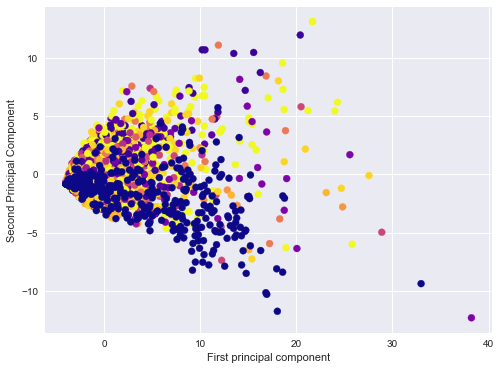

In [13]:
from sklearn.decomposition   import PCA;

pca = PCA(n_components=2);

pca.fit(X.toarray());

x_pca = pca.transform(X.toarray());

plt.figure(figsize=(8, 6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=y, cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3679
[t-SNE] Computed conditional probabilities for sample 2000 / 3679
[t-SNE] Computed conditional probabilities for sample 3000 / 3679
[t-SNE] Computed conditional probabilities for sample 3679 / 3679
[t-SNE] Mean sigma: 1.443311
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.822939
[t-SNE] Error after 250 iterations: 0.822939


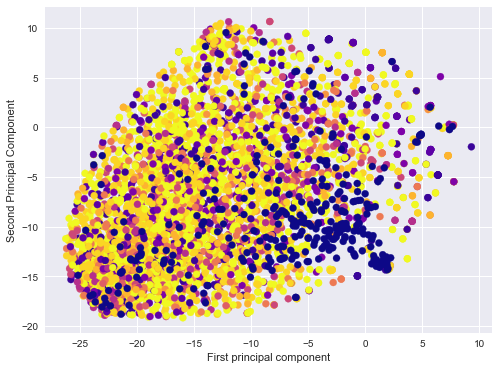

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y, cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

# How could we improve the event classifier?

- Use information about the time of day
- Use the location
- More intelligent feature design
- Augment training data (e.g. randomly drop some words or create a text generator)